Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
## importing drive
from google.colab import drive
drive.mount("/content/gdrive")

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
os.getcwd()

'/content'

In [4]:
## setting directory

os.chdir('/content/gdrive/My Drive/Machine Learning Journey/Git_Projects/Melonoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration/')
os.getcwd()

'/content/gdrive/My Drive/Machine Learning Journey/Git_Projects/Melonoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration'

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Train/")
data_dir_test = pathlib.Path("Test/")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg'))) #count of images
image_class_train = len(list(data_dir_train.glob('*'))) #count of folders (categories/classes)
print(f'number of train images is {image_count_train} in {image_class_train} classes \n')
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f'number of test images is {image_count_test}')

number of train images is 2239 in 9 classes 

number of test images is 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

seed = 123

Use 80% of the images for training, and 20% for validation.

In [8]:
## training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, label_mode='categorical', batch_size=batch_size,
                                                               image_size=(img_height, img_width), color_mode='rgb', validation_split=0.2,
                                                               subset='training', seed = seed)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, label_mode='categorical', batch_size=batch_size,
                                                               image_size=(img_height, img_width), color_mode='rgb', validation_split=0.2,
                                                               subset='validation', seed = seed)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
## list of skin conditions and cancers
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

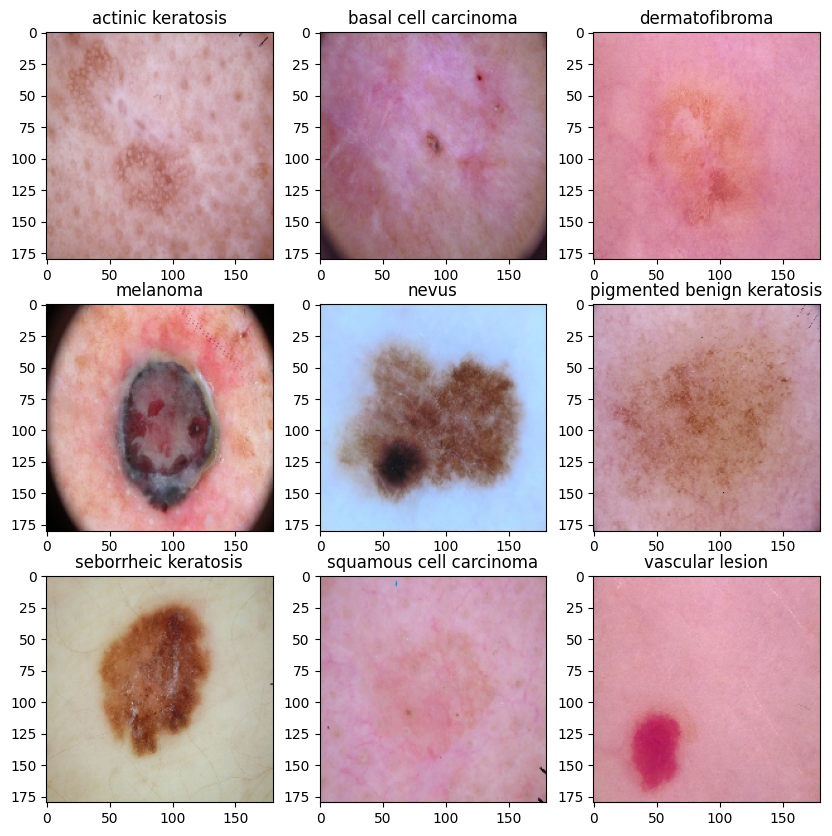

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image as per the class
files_path_dict = {}

for name in class_names:
    files_path_dict[name] = list(map(lambda x:str(data_dir_train)+'/'+name+'/'+x,os.listdir(str(data_dir_train)+'/'+name)))


#Visualize image
plt.figure(figsize=(10,10))
index = 0
for name in class_names:
    path_list = files_path_dict[name][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(name)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creation of Model 1


In [13]:
### model building code

channels = 3  ## number of channels RGB
input_shape = (img_height,img_width, channels)  ## shape of input is 180x180x3 tensor


def dense_module(input_tensor,f_1, f_2): #implementation of dense module module similar to densenet2 with multiple filters to get more info from pictures

    tower_1 = layers.Conv2D(f_1, (3, 3), padding='same', activation='relu')(input_tensor) ##f_1 is number of filter with size 3x3
    tower_2 = layers.Conv2D(f_2, (3, 3), padding='same', activation='relu')(input_tensor) ##f_2 == f_1 or f_1*2 with filter 3x3

    output = layers.Concatenate(axis=-1)([tower_1, tower_2])

    model = Model(inputs=input_tensor, outputs=output)
    return model


In [19]:
model1 = Sequential()

##input layer
model1.add(layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=input_shape))  ##input layer with rescaled inputs

##layer 1 1
#model1.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')) ## 32 filters of 3x3 with 0 padding w/ relu activation
model1.add(dense_module(model1.output, 16,32))
model1.add(layers.MaxPooling2D((2, 2)))

##layer 2
#model1.add(Conv2D(32, kernel_size=(3,3), activation='relu')) ## 32 filters of 3x3 with 0 padding w/ relu activation
model1.add(dense_module(model1.output, 32,64))
model1.add(layers.MaxPooling2D((2, 2)))#, strides=(1, 1), padding='same')


##layer 3
#model1.add(Conv2D(64, kernel_size=(3,3),padding='same', activation='relu')) ## 32 filters of 3x3 with 0 padding w/ relu activation
model1.add(dense_module(model1.output, 64,128))
model1.add(layers.MaxPooling2D((2, 2)))#, strides=(1, 1), padding='same')


##layer 4
model1.add(dense_module(model1.output, 128,128))
model1.add(layers.MaxPooling2D((2, 2)))#, strides=(1, 1), padding='same')

##layer 5
model1.add(layers.Flatten())

#layer 6
model1.add(layers.Dense(128, activation='relu'))

#layer 7
model1.add(layers.Dense(32, activation='relu'))

#output layer
model1.add(layers.Dense(image_class_train, activation='softmax'))



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [20]:
## selection of optimizer and loss function

sgd = SGD(momentum=0.5)
adam = Adam(amsgrad=True)

model1.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# View the summary of all layers
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 model_4 (Functional)        (None, 180, 180, 48)      1344      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 48)       0         
 2D)                                                             
                                                                 
 model_5 (Functional)        (None, 90, 90, 96)        41568     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 96)       0         
 2D)                                                             
                                                                 
 model_6 (Functional)        (None, 45, 45, 192)      

### Train the model

In [22]:
epochs = 20

history = model1.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 82ms/step - loss: 2.0500 - accuracy: 0.2467 - val_loss: 1.8053 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 4s 74ms/step - loss: 1.7933 - accuracy: 0.3259 - val_loss: 1.7185 - val_accuracy: 0.3669
Epoch 3/20
56/56 [==============================] - 4s 74ms/step - loss: 1.6108 - accuracy: 0.4342 - val_loss: 1.6327 - val_accuracy: 0.4519
Epoch 4/20
56/56 [==============================] - 4s 74ms/step - loss: 1.5220 - accuracy: 0.4565 - val_loss: 1.6835 - val_accuracy: 0.4161
Epoch 5/20
56/56 [==============================] - 4s 77ms/step - loss: 1.4193 - accuracy: 0.5033 - val_loss: 1.5118 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 4s 75ms/step - loss: 1.4453 - accuracy: 0.4933 - val_loss: 1.4169 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 4s 75ms/step - loss: 1.3747 - accuracy: 0.5173 - val_loss: 1.5130 - val_accuracy: 0.4944
Epoch 8/20
56

### Visualizing training results

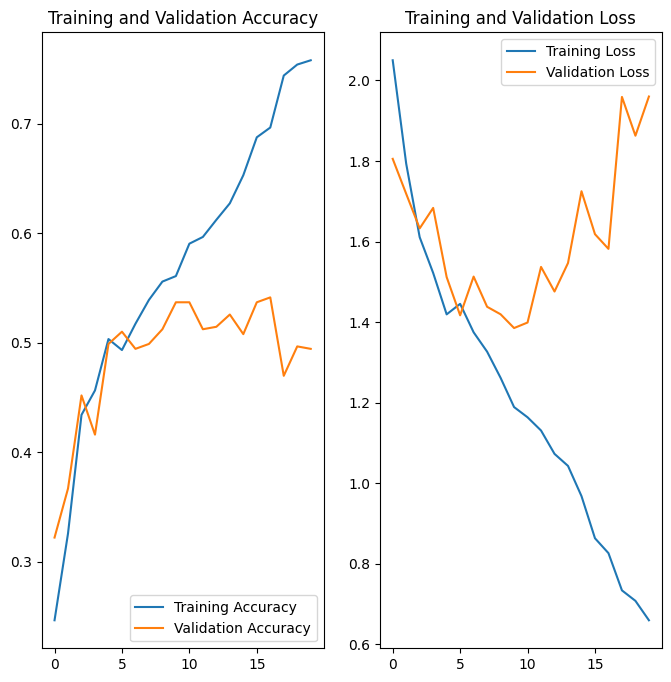

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training dataset has very good accuracy for the final fit in its history of ~0.8 with a loss of < 1.0. While this is good for a model on unaugmented data, the validdation set tells another story. While the loss for the validation set did initially decrease and accuracy closely followed the training set, this all changed around the 10th epoch where accuracy stalled around 0.5 and the loss began to grow with each subsequent fit. This implies that the model is overfitting on the training data.

This is to be expected becuase the images are quite varied even among conditions and the model is somewhat incentivised to learn the pattern of the training data, not the general pattern of all unseen data.

### Data Augmentation

https://www.datacamp.com/tutorial/complete-guide-data-augmentation

Using the above as a guide, I will opt to flip the images randomly, since cancers can come in numerous shapes, it be be also useful to conduct other rotations on the images, additionally

In [24]:
## Augmentation strategy

data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", seed=seed), ## randomly flip horizontally and vertically
    layers.RandomRotation(0.2, seed=seed), ## random roation of between -20% * 2pi, 20%*2pi - basically 0.2*360 degree rotations
    layers.RandomTranslation(0.1,0.1)
])

rescaler = Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

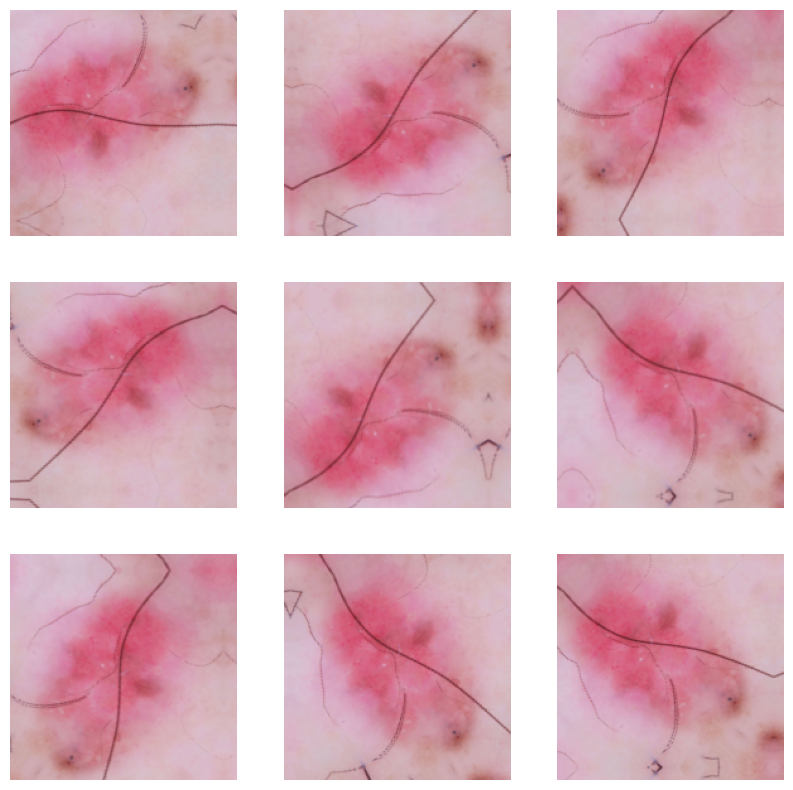

In [25]:
## visualisation augmentation
plt.figure(figsize=(10,10))

for image_batch, label_batch in train_ds.take(1):  #take one image from a one category in the training set
  for i in range(9): #number of images
    augmented_image = data_augmentation(image_batch) #image to augment
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype(int)) ## only ints, not floats can be displayed
    plt.axis("off")

### Model 2: Augmented Data and Dropout


In [26]:
model2 = Sequential()

##preprocessing layer
model2.add(layers.InputLayer(input_shape=input_shape))
model2.add(rescaler)
model2.add(data_augmentation)


##layer 1
model2.add(dense_module(model2.output, 16,32))
model2.add(layers.MaxPooling2D((2, 2)))

##layer 2

model2.add(dense_module(model2.output, 32,64))
model2.add(layers.MaxPooling2D((2, 2)))

##layer 3
model2.add(dense_module(model2.output, 64,128))
model2.add(layers.MaxPooling2D((2, 2)))


##layer 4
model2.add(dense_module(model2.output, 128,128))
model2.add(layers.MaxPooling2D((2, 2)))

##layer 5
model2.add(layers.Flatten())

#layer 6
model2.add(layers.Dense(128, activation='relu'))

#layer 7
model2.add(layers.Dense(32, activation='relu'))
#model2.add(layers.Dropout(0.5))

#output layer
model2.add(layers.Dense(image_class_train, activation='softmax'))



### Compiling the model

In [33]:
#for some reason i need to make this variable again

adam2 = Adam(amsgrad=True)

model2.compile(optimizer=adam2,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
# View the summary of all layers
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 model_8 (Functional)        (None, 180, 180, 48)      1344      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 48)       0         
 2D)                                                             
                                                                 
 model_9 (Functional)        (None, 90, 90, 96)        41568     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 96)       0         
 2D)                                                  

### Training the model

In [35]:
epochs = 25

history = model2.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 9s 78ms/step - loss: 2.0447 - accuracy: 0.2137 - val_loss: 1.8639 - val_accuracy: 0.2729
Epoch 2/25
56/56 [==============================] - 4s 73ms/step - loss: 1.9214 - accuracy: 0.2941 - val_loss: 1.9081 - val_accuracy: 0.3020
Epoch 3/25
56/56 [==============================] - 4s 74ms/step - loss: 1.8063 - accuracy: 0.3315 - val_loss: 1.6978 - val_accuracy: 0.3937
Epoch 4/25
56/56 [==============================] - 4s 73ms/step - loss: 1.6972 - accuracy: 0.3934 - val_loss: 1.6146 - val_accuracy: 0.4183
Epoch 5/25
56/56 [==============================] - 4s 74ms/step - loss: 1.6190 - accuracy: 0.4152 - val_loss: 1.5740 - val_accuracy: 0.4474
Epoch 6/25
56/56 [==============================] - 4s 74ms/step - loss: 1.5364 - accuracy: 0.4598 - val_loss: 1.6436 - val_accuracy: 0.4318
Epoch 7/25
56/56 [==============================] - 4s 74ms/step - loss: 1.5141 - accuracy: 0.4738 - val_loss: 1.5351 - val_accuracy: 0.4720
Epoch 8/25
56

### Visualizing the results

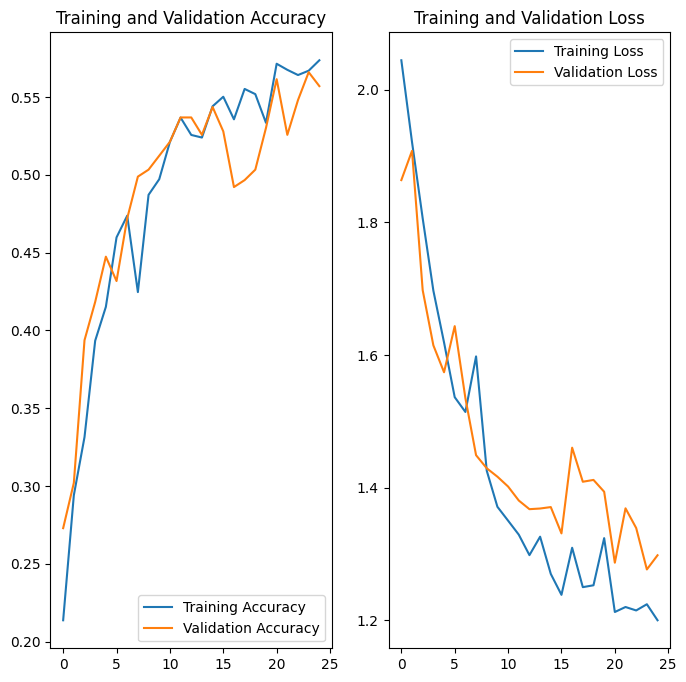

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- I have tried to run with and without the drop out layer and results remain similar. This indicates to me that the augmentation of the data aided in better generalisation as training and validation accuracies with closely tied.

- additionally, it appears overfitting can be reduced with data augmentation AND the correct inner structure, in this case parallelization of convolutions in each layer.

#### Class distributions

In [37]:
## evaluaion the number of instances in each class.

def class_distributions(directory):
    sub_directories = list(pathlib.Path(directory).glob('*'))

    counts = [len(list(path.glob('*'))) for path in sub_directories]
    class_names = [path.name for path in sub_directories]

    dataframe_of_classes = pd.DataFrame({'Class': class_names, 'No. of Image': counts})

    return dataframe_of_classes



distributions = class_distributions(data_dir_train)

distributions



,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,439
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


- there are clear class imbalances here.

- melanoma takes the cake with 438 sample images while seborrheic keratosis has the least with 77

- especially in this case, these imbalances are likely hindrances to learning. Some conditions, to the human eye appear similar therefore findinng the general pattern for those illnesses that distinguish them from others may be difficult for the model hence the original issues with overfitting, the model was simply forced top learn th training set in an attempt to compensate for the lack of samples.


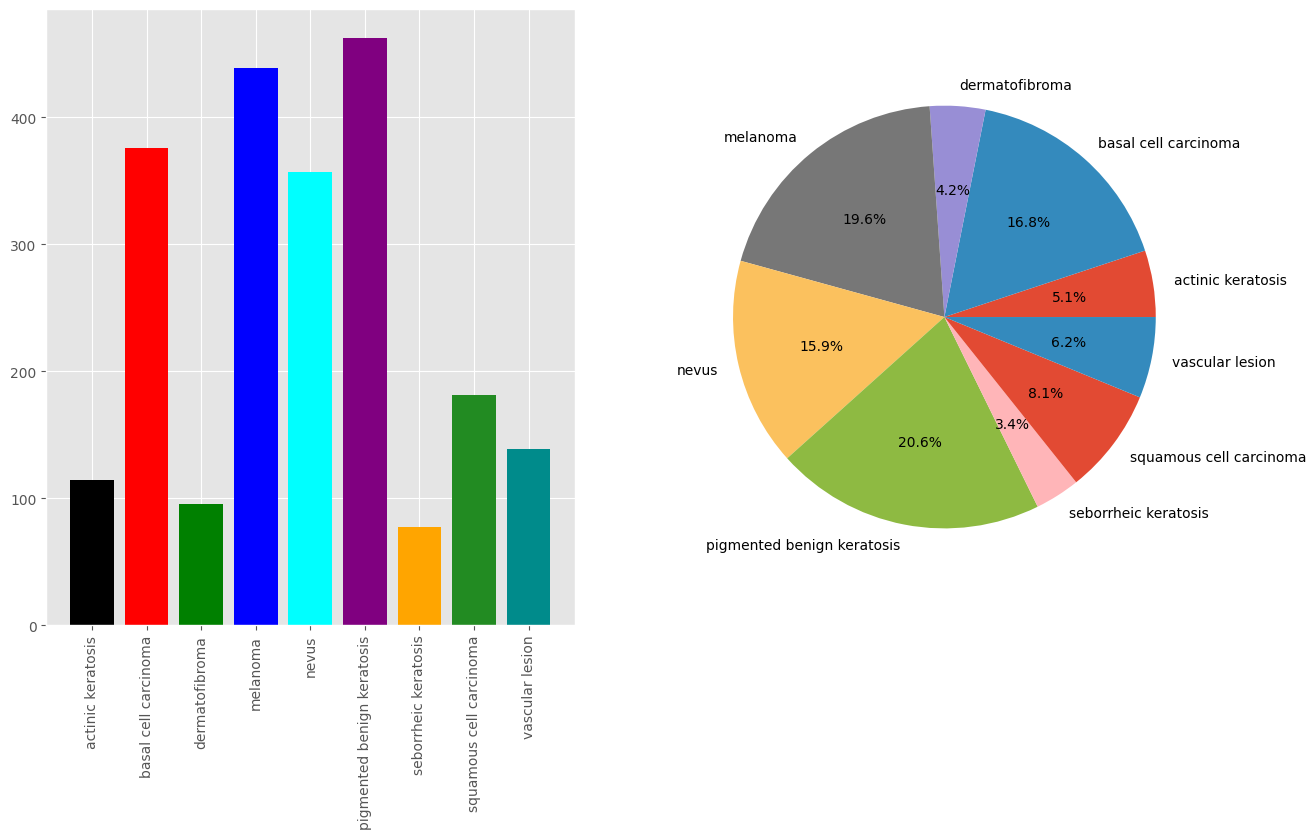

In [38]:
##visualise the imbalance with a barplot and pie chart

plt.figure(figsize=(15, 8))
plt.style.use("ggplot")

plt.subplot(1,2,1)
plt.bar(distributions['Class'], distributions['No. of Image'],
        color=['black', 'red', 'green', 'blue', 'cyan', 'purple', 'orange', 'forestgreen','darkcyan'])
plt.xticks(rotation = 90)

plt.subplot(1,2,2)
plt.pie(distributions['No. of Image'], labels = distributions['Class'], autopct='%1.1f%%')

plt.show()


#### **Rectifying class imbalances**
#### **Context:** a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) can be used to add more samples across all classes so that none of the classes have very few samples.

In [39]:
%%capture
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [40]:
os.getcwd()

'/content/gdrive/MyDrive/Machine Learning Journey/Git_Projects/Melonoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration'

In [41]:
path_to_training_dataset="Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB4707CBAF0>: 100%|██████████| 500/500 [00:11<00:00, 43.54 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB470617100>: 100%|██████████| 500/500 [00:14<00:00, 34.16 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB4901A2DA0>: 100%|██████████| 500/500 [00:13<00:00, 36.06 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB4E53972E0>: 100%|██████████| 500/500 [00:44<00:00, 11.22 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB490335F90>: 100%|██████████| 500/500 [00:49<00:00, 10.19 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB4E5333670>: 100%|██████████| 500/500 [00:09<00:00, 51.01 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB4E57803A0>: 100%|██████████| 500/500 [00:23<00:00, 21.69 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB4E545E0B0>: 100%|██████████| 500/500 [00:10<00:00, 48.01 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB4E534C310>: 100%|██████████| 500/500 [00:09<00:00, 52.31 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [42]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [43]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[2999]

'Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025063.jpg_f8586a37-cd23-4dae-b874-d4b739fdc790.jpg'

In [44]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[0:9]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [46]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [47]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [48]:
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training using augmented data

In [49]:
batch_size = 32
img_height = 180
img_width = 180

In [50]:
os.getcwd()

'/content/gdrive/MyDrive/Machine Learning Journey/Git_Projects/Melonoma_Detection/Skin cancer ISIC The International Skin Imaging Collaboration'

#### new train dataset


In [51]:
data_dir_train="Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, label_mode='categorical', batch_size=batch_size,
                                                               image_size=(img_height, img_width), color_mode='rgb', validation_split=0.2,
                                                               subset='training', seed = seed)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### new validation dataset

In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, label_mode='categorical', batch_size=batch_size,
                                                               image_size=(img_height, img_width), color_mode='rgb', validation_split=0.2,
                                                               subset='validation', seed = seed)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model inclusive of batch normalisation

In [53]:
## model 3 code

model3 = Sequential()

##preprocessing layer
model3.add(layers.InputLayer(input_shape=input_shape))
model3.add(rescaler)
model3.add(data_augmentation)


##layer 1
model3.add(dense_module(model3.output, 16,32))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D((2, 2)))

##layer 2

model3.add(dense_module(model3.output, 32,64))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D((2, 2)))

##layer 3
model3.add(dense_module(model3.output, 64,128))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D((2, 2)))


##layer 4
model3.add(dense_module(model3.output, 128,128))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D((2, 2)))

##layer 5
model3.add(dense_module(model3.output, 128,256))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(dense_module(model3.output, 256,256))
model3.add(layers.MaxPooling2D((2, 2)))

##layer 6
model3.add(layers.Flatten())

#layer 7
model3.add(layers.Dense(128, activation='relu'))

#layer 8
model3.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dropout(0.5))

#output layer
model3.add(layers.Dense(len(class_names), activation='softmax'))


#### Model Compilation

In [54]:
## compile with adam and cross entropy

adam3 = Adam(amsgrad=True)
model3.compile(optimizer=adam3,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
# View the summary of all layers
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 model_12 (Functional)       (None, 180, 180, 48)      1344      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 48)       0         
 g2D)                                                            
                                                                 
 model_13 (Functional)       (None, 90, 90, 96)        41568     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 96)       0         
 g2D)                                                 

#### Model Training

In [56]:
## fitting with 50 epochs
epochs = 50

history = model3.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs
)


Epoch 1/50
169/169 [==============================] - 30s 139ms/step - loss: 1.8803 - accuracy: 0.2843 - val_loss: 1.7707 - val_accuracy: 0.3059
Epoch 2/50
169/169 [==============================] - 22s 129ms/step - loss: 1.5753 - accuracy: 0.3878 - val_loss: 2.1924 - val_accuracy: 0.2739
Epoch 3/50
169/169 [==============================] - 22s 126ms/step - loss: 1.4673 - accuracy: 0.4191 - val_loss: 3.4196 - val_accuracy: 0.2539
Epoch 4/50
169/169 [==============================] - 22s 127ms/step - loss: 1.4391 - accuracy: 0.4288 - val_loss: 1.9709 - val_accuracy: 0.3192
Epoch 5/50
169/169 [==============================] - 22s 126ms/step - loss: 1.4003 - accuracy: 0.4497 - val_loss: 1.6379 - val_accuracy: 0.4039
Epoch 6/50
169/169 [==============================] - 22s 127ms/step - loss: 1.3717 - accuracy: 0.4551 - val_loss: 1.4077 - val_accuracy: 0.4477
Epoch 7/50
169/169 [==============================] - 22s 126ms/step - loss: 1.3593 - accuracy: 0.4681 - val_loss: 3.0784 - val_ac

#### Visualize the model results

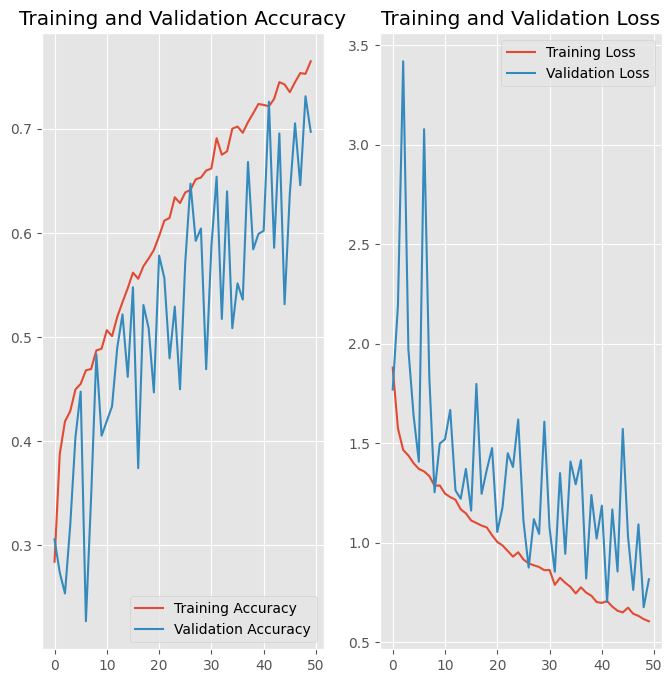

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze rresults. underfitting/overfitting? Did class rebalance help?

